# Generating dataset

In [4]:
import sys
sys.path.append('../simulator')

from AgentBasedModel import *
from AgentBasedModel.extra import *
import AgentBasedModel.settings as settings
from AgentBasedModel.visualization import (
    plot_price,
    plot_price_fundamental,
    plot_liquidity,
    plot_orderbook_imbalance,
    plot_trade_imbalance,
    plot_spread,
    plot_gain
)
from random import randint
from pathlib import Path

datasets_quantity = 1

stocks_quantity = 10

simulator_iterations = 5000

risk_free_rate = 5e-4
        
price = 100
        
dividend = price * risk_free_rate


assets = [
    Stock(dividend) for _ in range(stocks_quantity)
]

# Exchange agent (intermediary between market and customer)
exchanges = [
    ExchangeAgent(assets[i], risk_free_rate) for i in range(stocks_quantity) #for x in range(10)   # single asset
]

# Market customers
traders = [
    *[Random(exchanges[randint(0, stocks_quantity - 1)])         for _ in range(250)],
    *[Fundamentalist(exchanges[randint(0, stocks_quantity - 1)]) for _ in range(250)],
    *[Chartist2D(exchanges)                                      for _ in range(100)],
    *[MarketMaker2D(exchanges)                                   for _ in range(20)]
]

# Run simulation
simulator = Simulator(**{
    'assets': assets,
    'exchanges': exchanges,
    'traders': traders,
})


def simulate() -> SimulatorInfo:
    # Initialization of stocks

    info = simulator.info

    simulator.simulate(simulator_iterations, silent=False)

    return info
      

# Saving metrics
def collect_save_dataset(info: SimulatorInfo, path):

    metrics = {
        #"gain": lambda:plot_gain(info, idx = 1, left_iter=1, right_iter=simulator_iterations, show = True),
        #"spread":lambda:plot_spread(info, idx = 1, left_iter=1, right_iter=simulator_iterations, show = True),
        #"obi":lambda:plot_orderbook_imbalance(info, show=True,level = 10),
        #"timb":lambda:plot_trade_imbalance(info, delta = 1, show = True),
        #"obi_1":lambda:plot_orderbook_imbalance(info,show = True, level = 1),
        #"obi_2":lambda:plot_orderbook_imbalance(info,show = True, level = 2),    
        "price":lambda:plot_price(info, show = False, spread=False)
    }

    for i in range(10):
       metrics[f'obi_level_{i+1}'] = lambda i = i:plot_orderbook_imbalance(info,level = i+1, show = False)

    for i in range(10):
        metrics[f'tfi_delta_{i}'] = lambda i = i:plot_trade_imbalance(info,delta = i+1,show = False)

    for metric, func in metrics.items():
        dataset = func()
        dataset.to_csv(path + '/' + f'{metric}.csv')         
           
            

In [2]:
train_info = simulate()

Simulation: 100%|██████████| 5000/5000 [07:05<00:00, 11.75it/s]


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


c:\Users\aslan\OneDrive\Рабочий стол\Coursework\models\../simulator\AgentBasedModel\visualization\market.py:191: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


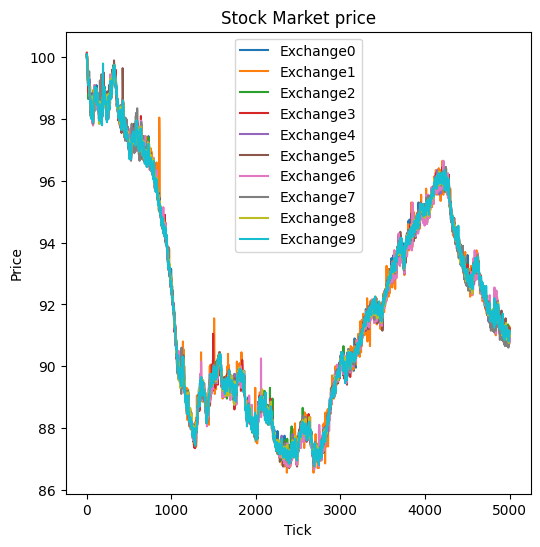

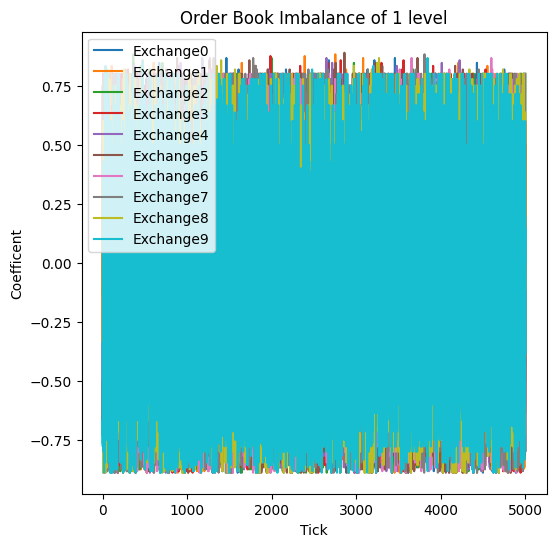

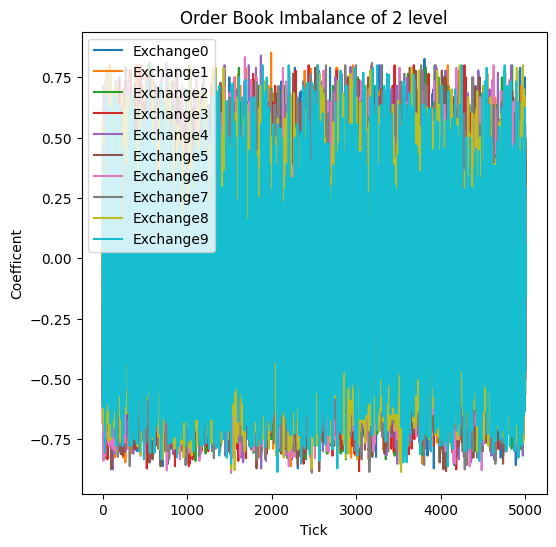

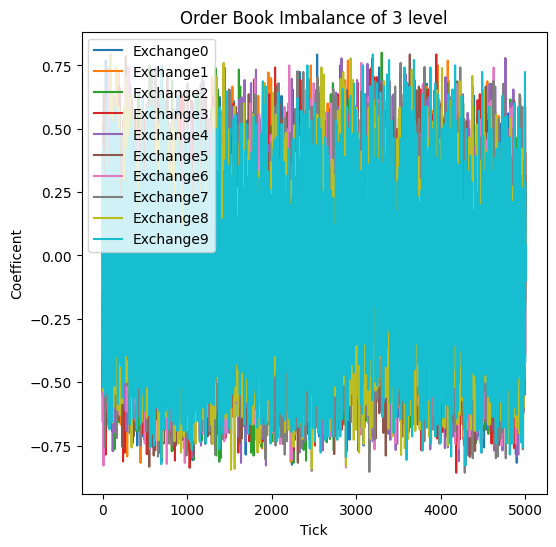

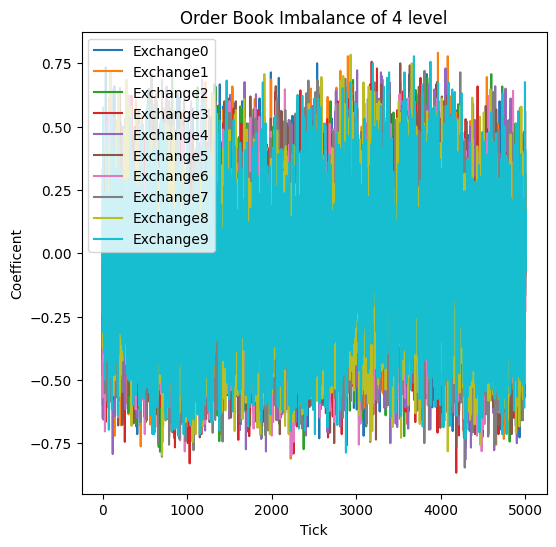

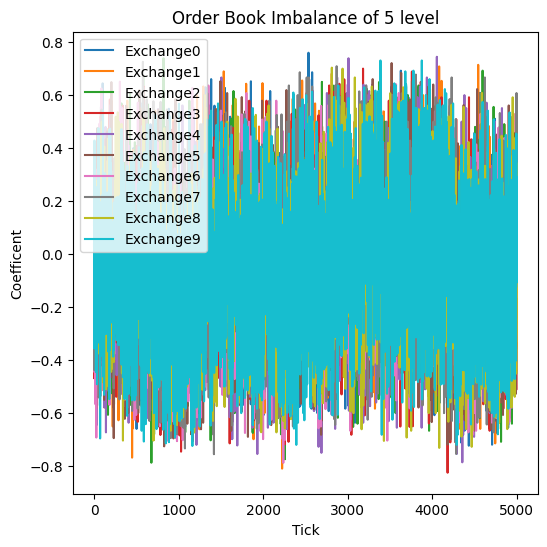

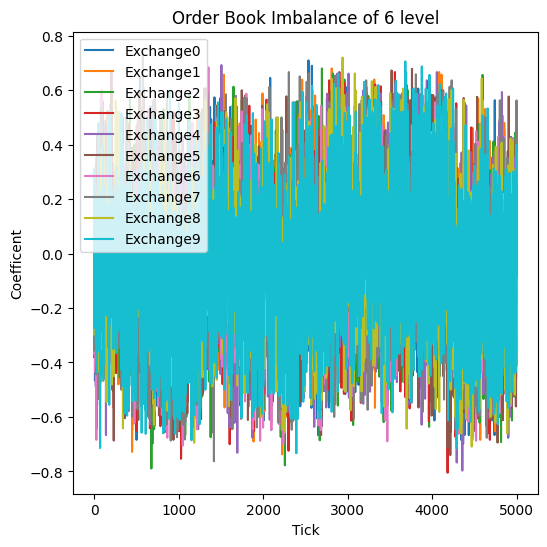

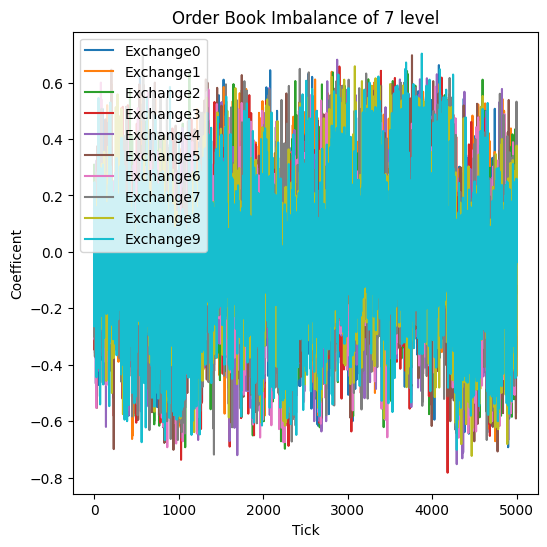

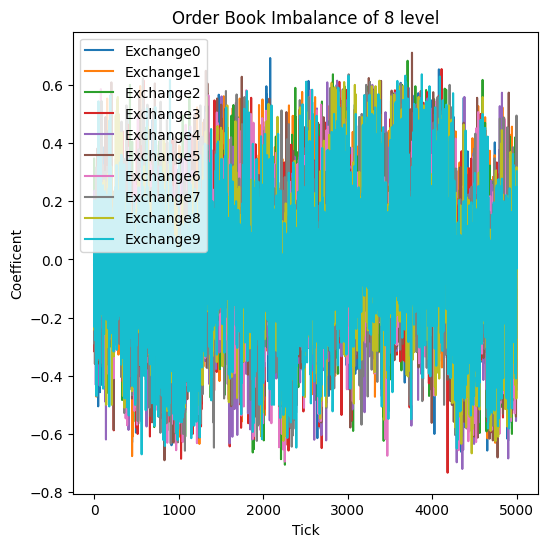

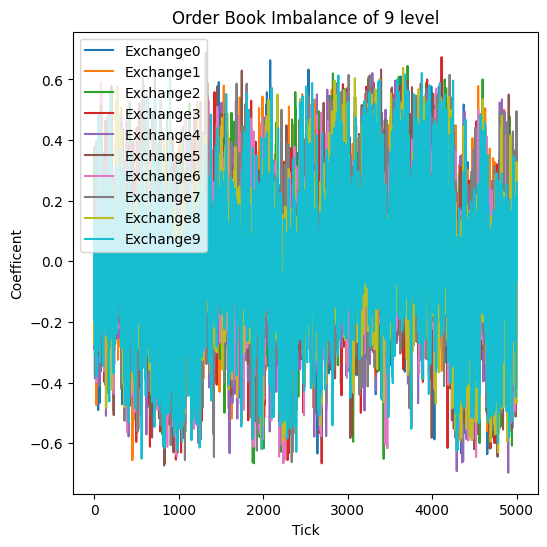

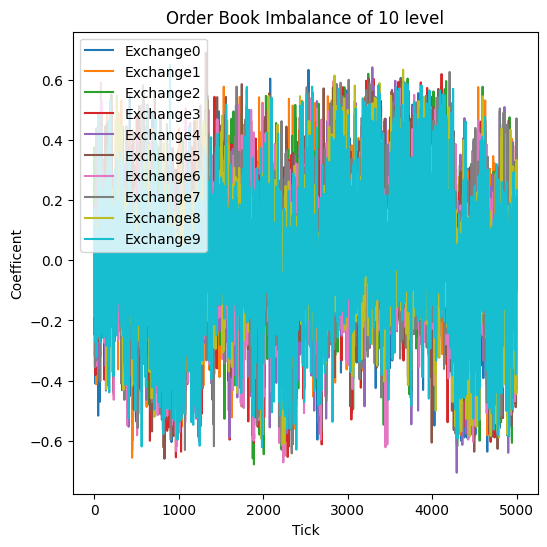

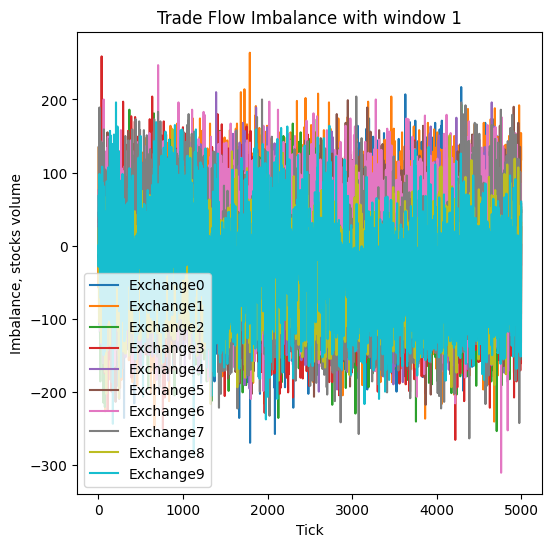

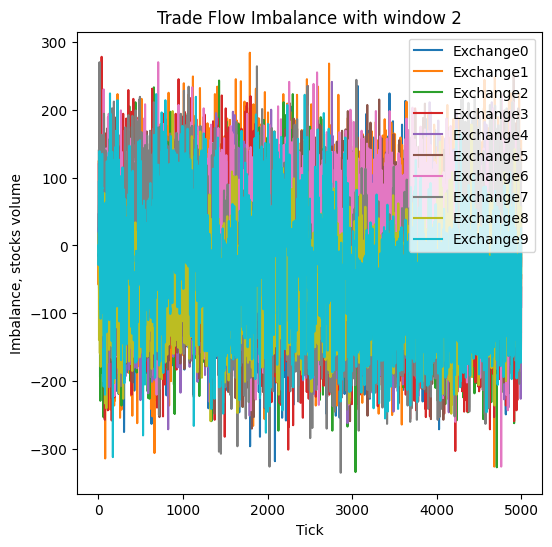

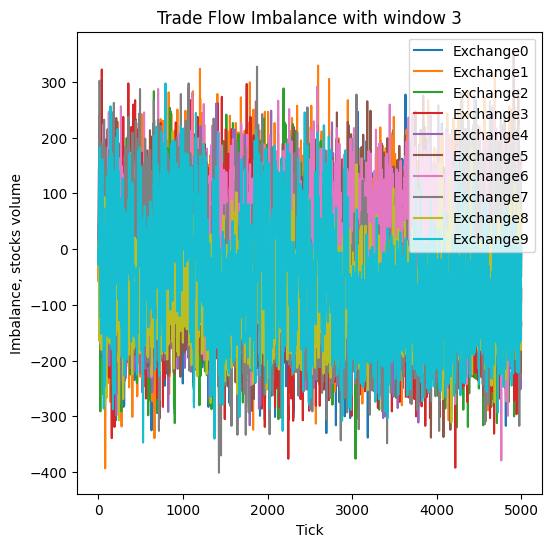

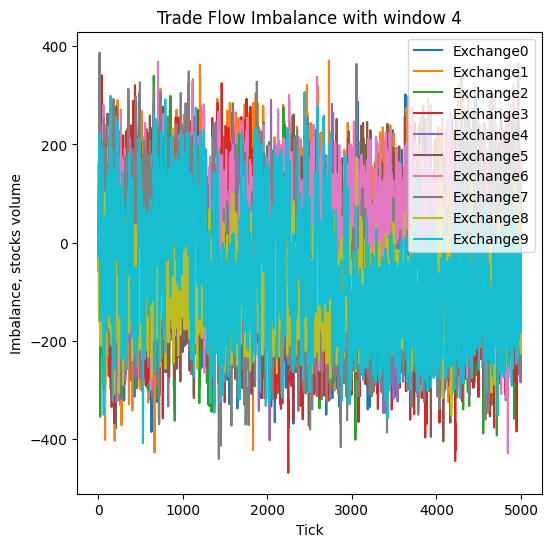

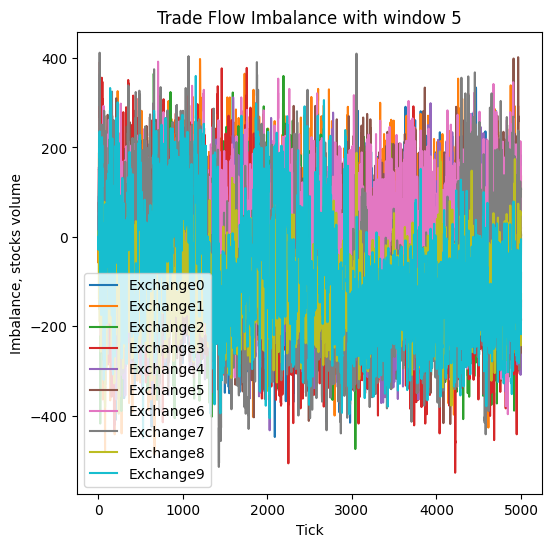

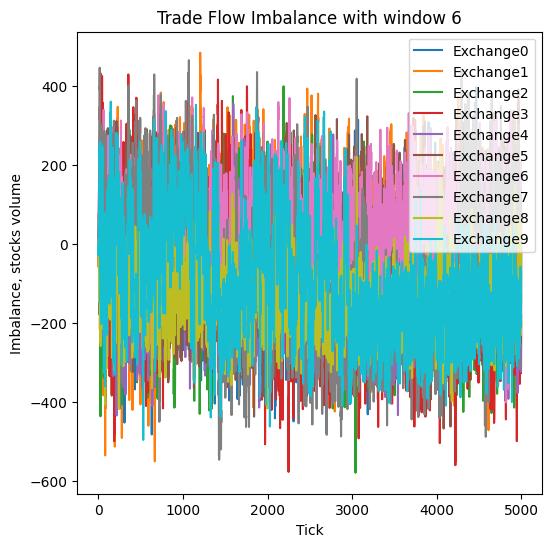

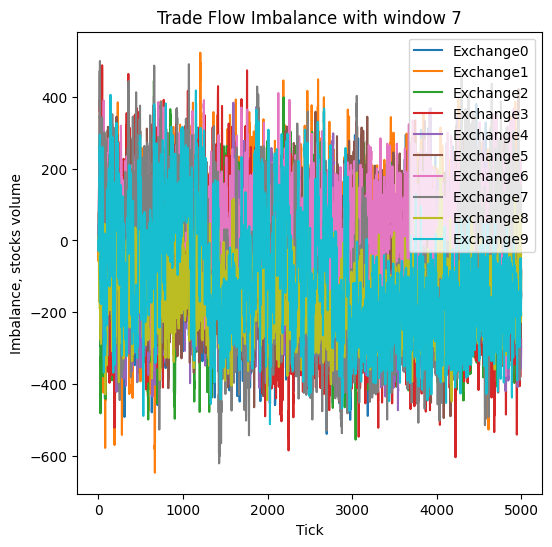

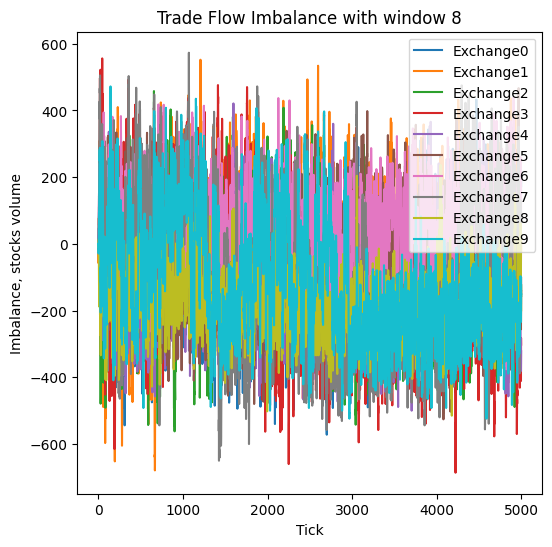

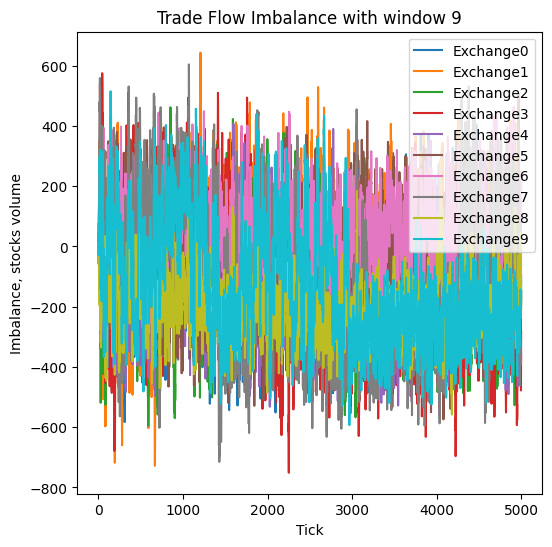

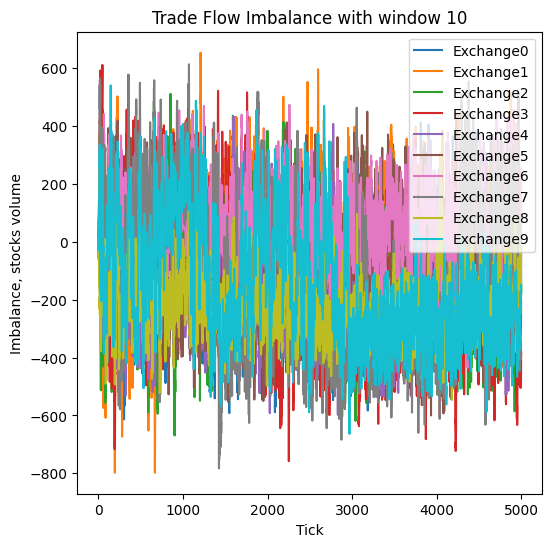

In [6]:
# train dataset
collect_save_dataset(train_info,'../dataset/train')

Simulation: 100%|██████████| 2500/2500 [02:40<00:00, 15.57it/s]


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


c:\Users\aslan\OneDrive\Рабочий стол\Coursework\models\../simulator\AgentBasedModel\visualization\market.py:191: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


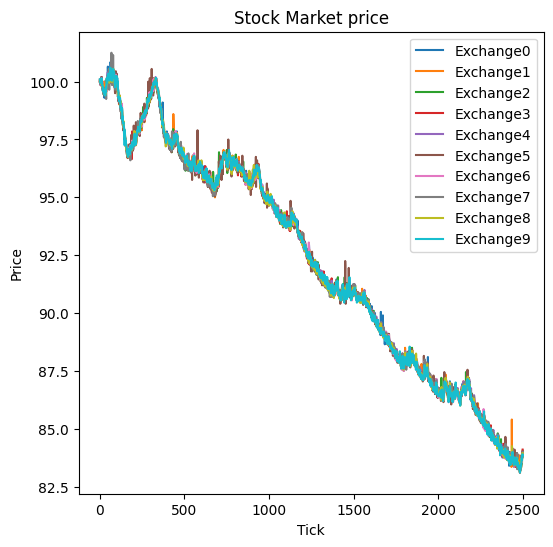

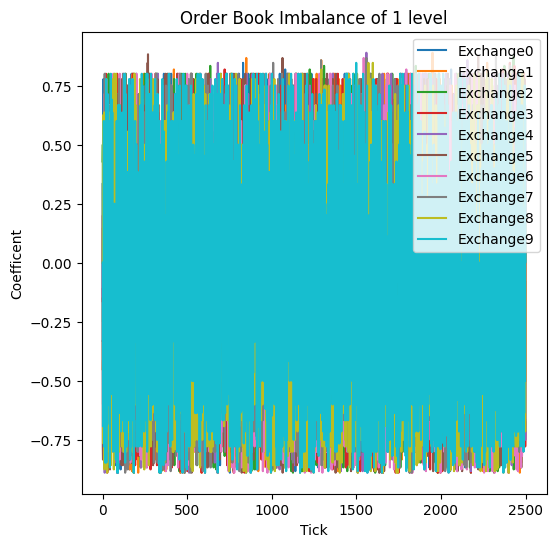

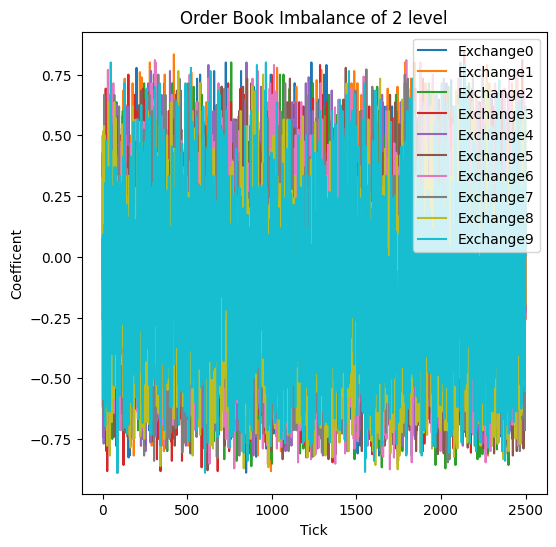

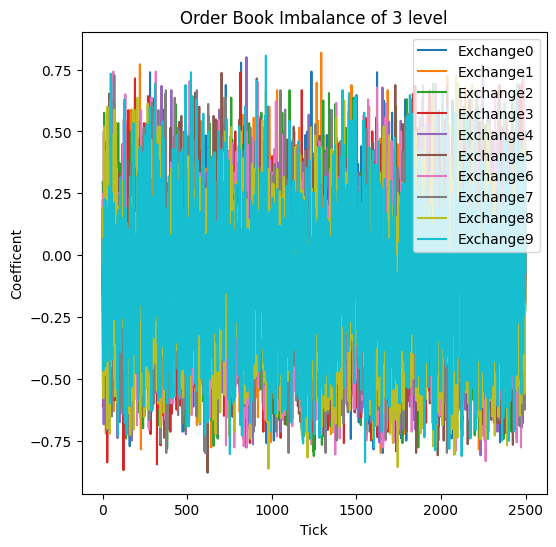

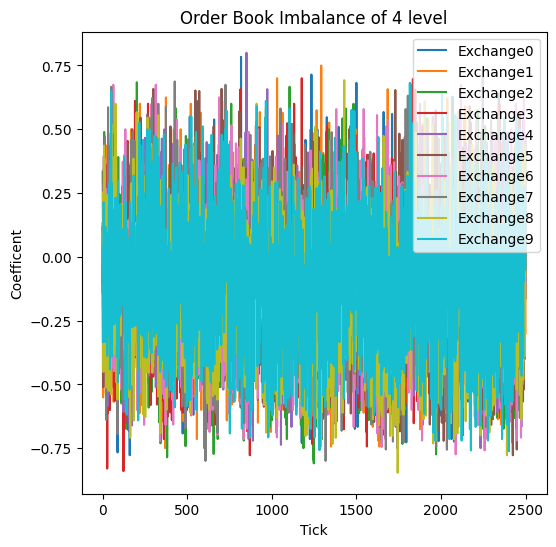

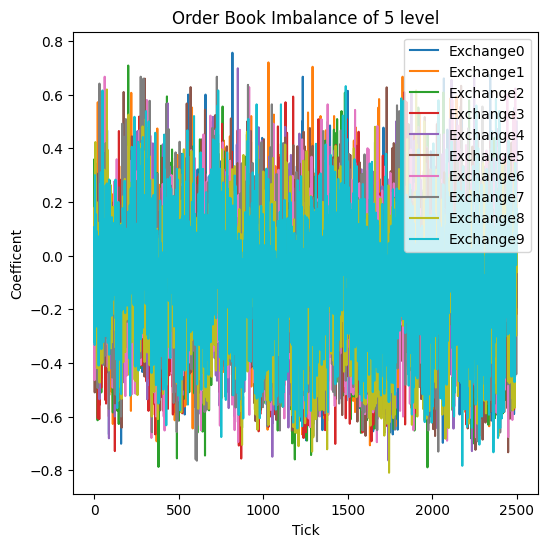

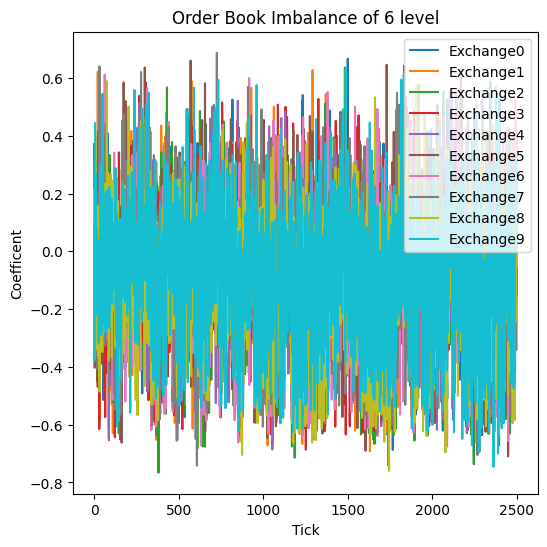

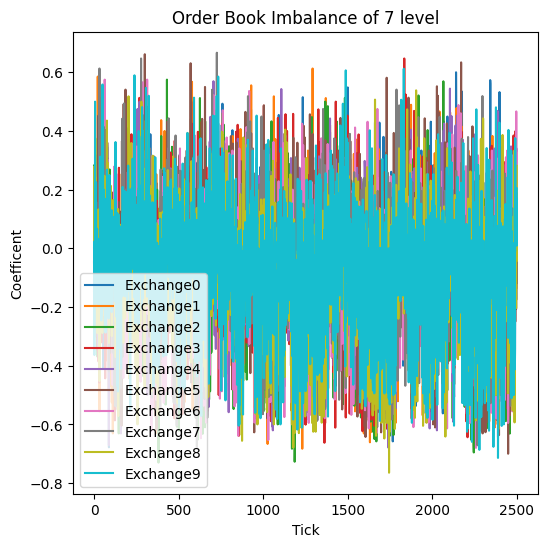

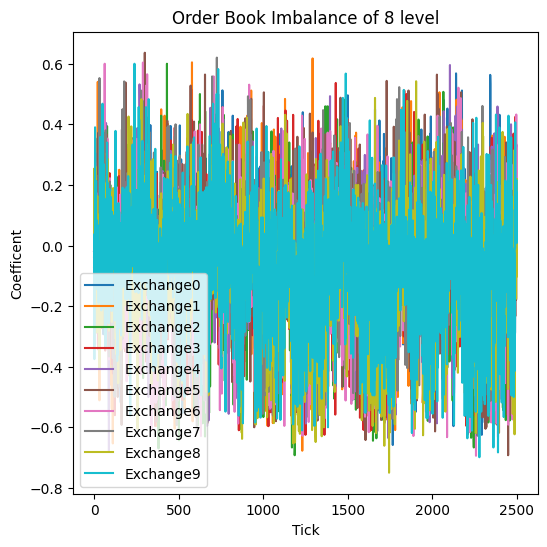

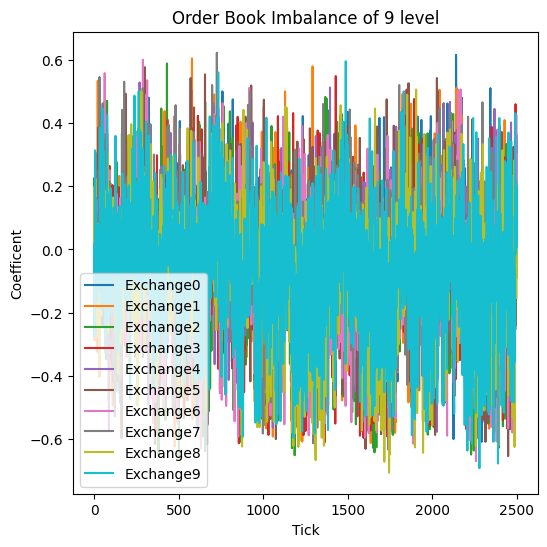

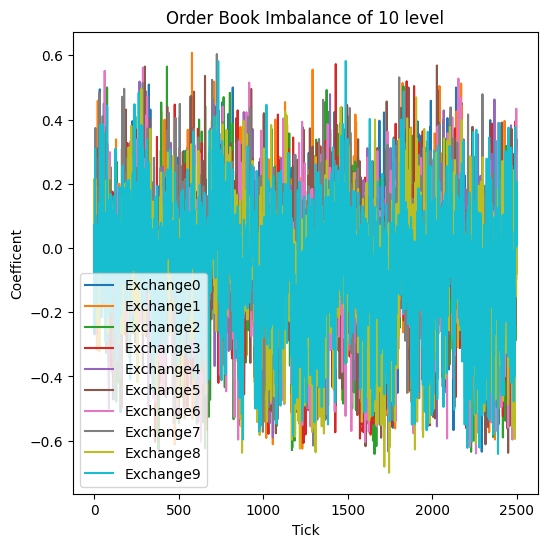

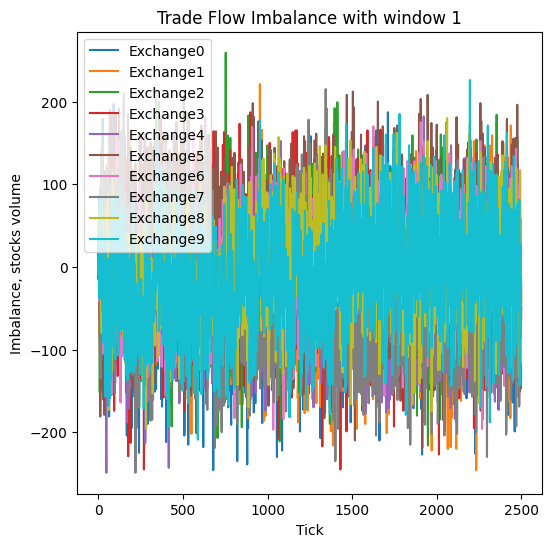

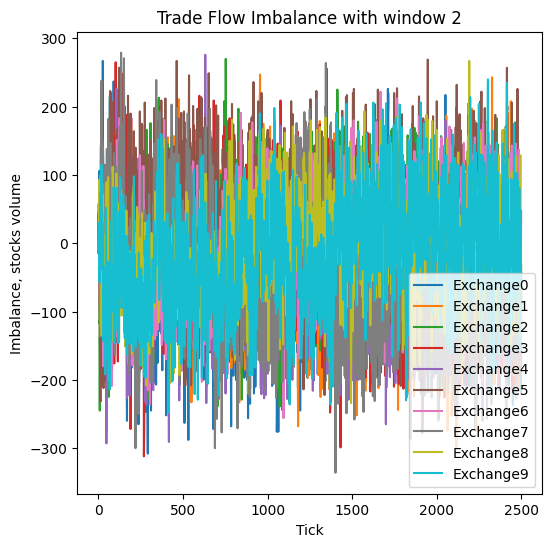

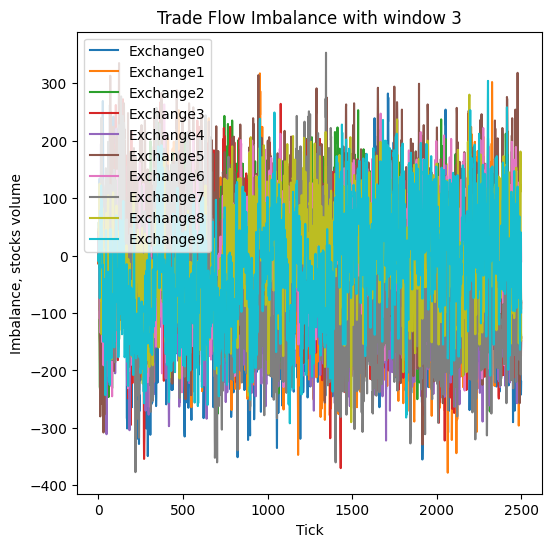

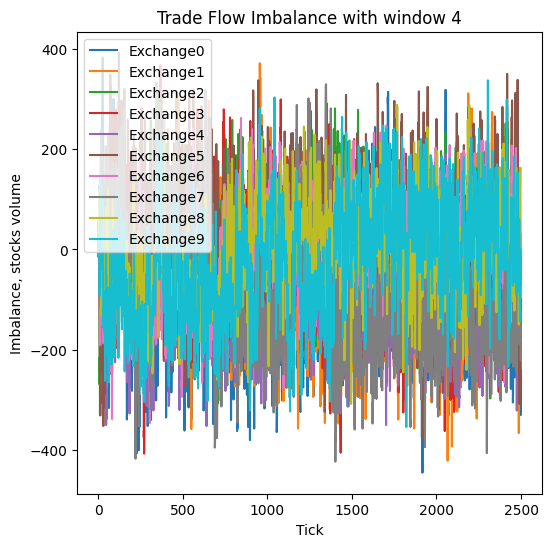

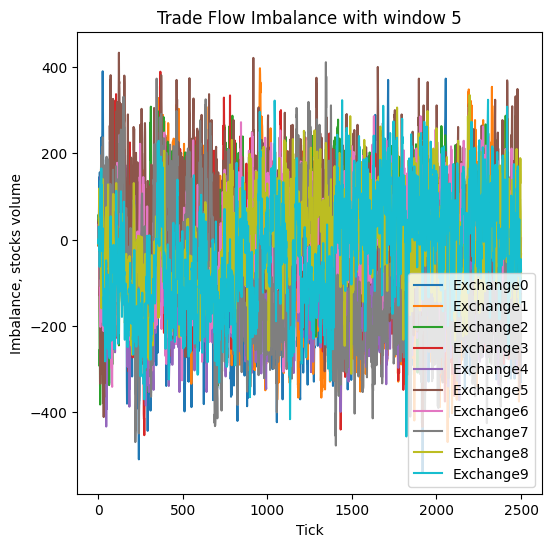

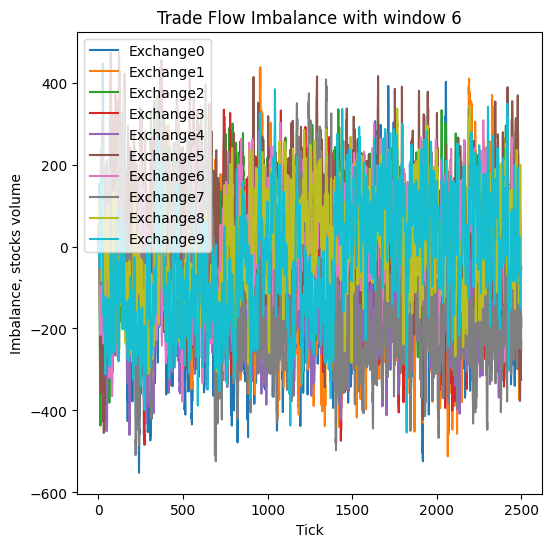

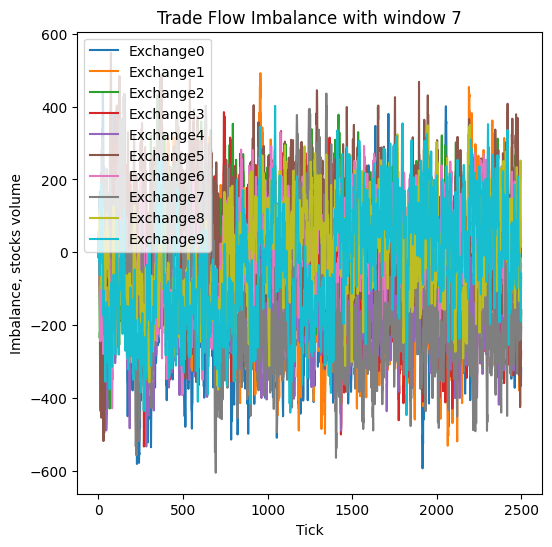

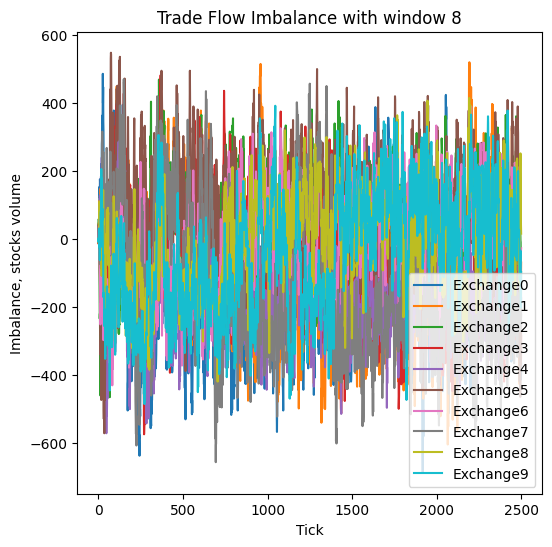

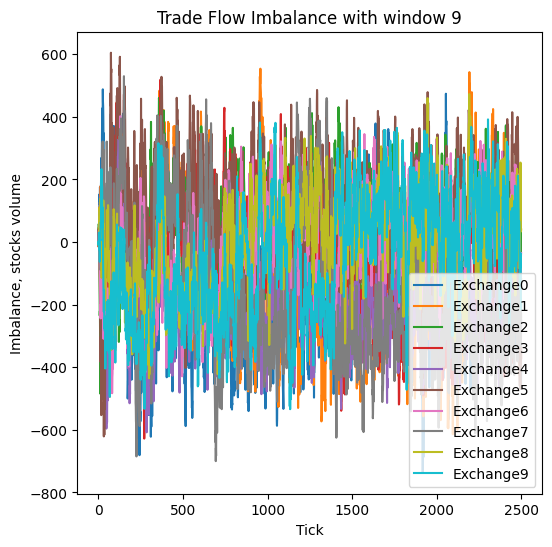

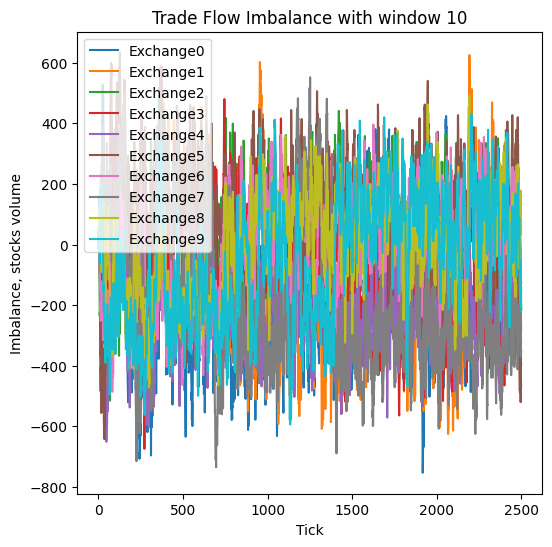

In [2]:
# test dataset
simulator_iterations = 2500

test_info = simulate()

collect_save_dataset(test_info,f'../dataset/test')

# Data processing

In [56]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn
import catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import seaborn as sns

In [2]:
# reading files

def get_metrics(directory, filter: str = None):

    files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    
    dfs = {}

    for file in files:
        if re.search(f"{filter}.*",file):
            file_path = os.path.join(directory,file)
            df = pd.read_csv(file_path)
            df.drop(df.columns[0],inplace = True,axis = 1)
            dfs[file] = df
    
    return dfs

def concat(dfs: pd.DataFrame):
    array_X = []

    for i in range(stocks_quantity):
        array_X.append(pd.concat([value.iloc[:,:i+1] for key, value in dfs.items()],axis = 1))
    
    return array_X

In [5]:
obis = get_metrics('../dataset/train/',filter = 'obi')
tfis = get_metrics('../dataset/train/',filter = 'tfi')
all = get_metrics('../dataset/train/',"")

array_X_obis = concat(obis)
array_X_tfis = concat(tfis)
array_X = concat(all)

<Axes: >

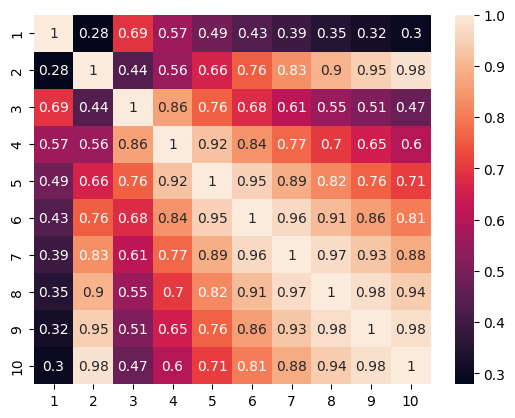

In [44]:
array_X_obis[0].columns = [i+1 for i in range(array_X_obis[0].shape[1])]

sns.heatmap(array_X_obis[0].corr(), annot = True)

<Axes: >

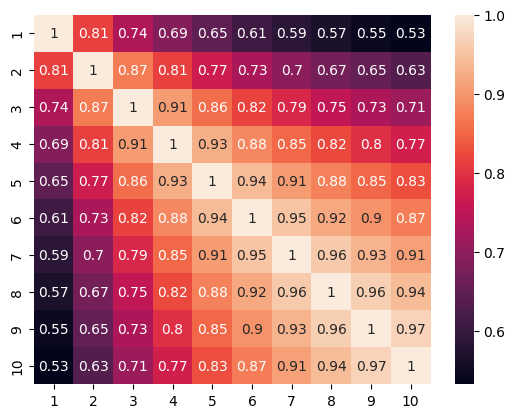

In [42]:
array_X_tfis[0].columns = [i+1 for i in range(array_X_obis[0].shape[1])]

sns.heatmap(array_X_tfis[0].corr(),annot=True)

In [58]:
print('Explained variance ratio for OBIs: \n',PCA().fit(array_X_obis[0]).explained_variance_)

Explained variance ratio for OBIs: 
 [4.65601293e-01 1.43893329e-01 4.78529196e-02 1.65356192e-02
 6.31136731e-03 2.68419211e-03 1.31285792e-03 7.08601193e-04
 4.01050332e-04 2.28026091e-04]


In [56]:
print('Explained variance ratio for TFIs: \n',PCA().fit(array_X_tfis[0]).explained_variance_)

Explained variance ratio for TFIs: 
 [156782.66020184  10433.36699014   3543.5841704    1851.33694988
   1262.352605     1032.15692023    865.37746876    683.80467562
    642.39332705    630.62917844]


In [8]:
y = all['price.csv']['0']

## Reducing overfitting

In [6]:
from sklearn.decomposition import PCA

for i in range(len(array_X)):
    pca = PCA(n_components = (2 * (i+1)),random_state=42)
    array_X[i] = pca.fit_transform(array_X[i])
    array_X_obis[i] = pca.fit_transform(array_X_obis[i])
    array_X_tfis[i] = pca.fit_transform(array_X_tfis[i])

## Training

In [19]:
def train(array_of_X,y):
    models = {
        'Linear Regression': (LinearRegression(), {'fit_intercept': [True, False]}),
        'Random Forest': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
        #'XGBoost': (XGBRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
        'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
        #'CatBoost': (CatBoostRegressor(silent = True), {'iterations': [50, 100, 200], 'depth': [5, 10, 15]}),
    }


    rsquared_results = []

    for i, X in enumerate(array_of_X):
        X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=42)

        results = {}

        # Iterate over each model and perform GridSearchCV
        for model_name, (model, params) in models.items():
            print(f"Training {model_name}...")
            grid_search = GridSearchCV(model, params, scoring='r2', cv=2)
            grid_search.fit(X_train, y_train)
            
            # Get the best estimator from GridSearchCV
            best_model = grid_search.best_estimator_
            
            # Evaluate the model on the test set
            y_pred = best_model.predict(X_test)
            rsquared_ = r2_score(y_test, y_pred)
            
            # Store the results in the dictionary
            results[model_name] = {'best_model': best_model, 'rsquared': rsquared_}

        # Print the results
        for model_name, result in results.items():
            print(f"{model_name} using first {i} stocks features: R^2 = {result['rsquared']}")

        rsquared_results.append(results)


# You can access the best model for each algorithm as follows:
# best_linear_regression_model = results['Linear Regression']['best_model']
# best_random_forest_model = results['Random Forest']['best_model']
# best_xgboost_model = results['XGBoost']['best_model']
# best_gradient_boosting_model = results['Gradient Boosting']['best_model']
# best_catboost_model = results['CatBoost']['best_model']


### Price and Cross impact of integrated OBIs

In [88]:
train(array_X_obis,y)

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 0 stocks features: R^2 = -0.0032079833648899214
Random Forest using first 0 stocks features: R^2 = -0.008582111853370211
Gradient Boosting using first 0 stocks features: R^2 = -0.02327517436267068
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 1 stocks features: R^2 = -0.00437985053820511
Random Forest using first 1 stocks features: R^2 = -0.003999697947309144
Gradient Boosting using first 1 stocks features: R^2 = -0.023766801851785146
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 2 stocks features: R^2 = -0.0033726037956760546
Random Forest using first 2 stocks features: R^2 = -0.010759850671649529
Gradient Boosting using first 2 stocks features: R^2 = -0.03731005140662469
Training Linear Regression...
Training Random Forest...
Traini

In [89]:
train(array_X_tfis,y)

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 0 stocks features: R^2 = 0.022091461289902026
Random Forest using first 0 stocks features: R^2 = 0.010453567426374155
Gradient Boosting using first 0 stocks features: R^2 = -0.0034298052828827252
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 1 stocks features: R^2 = 0.12010880455573325
Random Forest using first 1 stocks features: R^2 = 0.18150984450364016
Gradient Boosting using first 1 stocks features: R^2 = 0.16580403816272904
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 2 stocks features: R^2 = 0.13114309924774026
Random Forest using first 2 stocks features: R^2 = 0.30957986331623877
Gradient Boosting using first 2 stocks features: R^2 = 0.2676526881745963
Training Linear Regression...
Training Random Forest...
Training Gradient B

In [90]:
train(array_X,y)

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 0 stocks features: R^2 = 0.022099775554868195
Random Forest using first 0 stocks features: R^2 = 0.011465870415885093
Gradient Boosting using first 0 stocks features: R^2 = 0.002373039254322973
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 1 stocks features: R^2 = 0.12019273614664694
Random Forest using first 1 stocks features: R^2 = 0.17577448067866996
Gradient Boosting using first 1 stocks features: R^2 = 0.16583561554397264
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 2 stocks features: R^2 = 0.13127346743442914
Random Forest using first 2 stocks features: R^2 = 0.30748186292209423
Gradient Boosting using first 2 stocks features: R^2 = 0.2719348436744965
Training Linear Regression...
Training Random Forest...
Training Gradient Boo

## Predicting future returns

In [14]:
def find_gain(price, delta = 1):
    gain = price.diff(delta)
    gain[0:delta] = 0.0
    return gain

In [20]:
gain_1 = find_gain(y,delta = 1)

train(array_X,gain_1)

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 0 stocks features: R^2 = 0.02646506884587496
Random Forest using first 0 stocks features: R^2 = 0.017837657674289242
Gradient Boosting using first 0 stocks features: R^2 = 0.012775383795214812
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 1 stocks features: R^2 = 0.03804662852905649
Random Forest using first 1 stocks features: R^2 = 0.01858263266412319
Gradient Boosting using first 1 stocks features: R^2 = -0.03623974453196266
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Linear Regression using first 2 stocks features: R^2 = 0.046838376248977465
Random Forest using first 2 stocks features: R^2 = 0.034541082362856246
Gradient Boosting using first 2 stocks features: R^2 = 0.01917359655605455
Training Linear Regression...
Training Random Forest...
Training Gradient 

In [53]:
gains = [find_gain(y,i+1) for i in range(100)]

In [54]:
test_price = get_metrics('../dataset/train/',filter = 'price')['price.csv'].iloc[0]

test_tfis = get_metrics('../dataset/train/',filter = 'tfi')

array_X_tfi_test = concat(test_tfis)

for i in range(len(array_X)):
    pca = PCA(n_components = (2 * (i+1)),random_state=42)
    array_X_tfi_test[i] = pca.fit_transform(array_X_tfi_test[i])

In [55]:
from sklearn.linear_model import Ridge


linear_model = Ridge()

results = []

for i, gain in enumerate(gains):
    X_tfi_train, X_tfi_test, gain_train, gain_test = train_test_split(array_X_tfis[3],gain,random_state=42)
    
    linear_model.fit(X_tfi_train,gain_train)

    predicts = linear_model.predict(X_tfi_test)

    test_predicts = linear_model.predict(array_X_tfi_test[3])

    positive_test_predicts = test_predicts > 0.0

    results.append(sum(positive_test_predicts)) 

    print(f'Result: {results[i]}')

    rscore = r2_score(gain_test,predicts)

    print(f'Gain with window {i+1}: {rscore}')

Result: 2482
Gain with window 1: 0.052655049599245496
Result: 2411
Gain with window 2: 0.11641582942223139
Result: 2406
Gain with window 3: 0.19418002442515114
Result: 2395
Gain with window 4: 0.24333457834115002
Result: 2382
Gain with window 5: 0.25346987283815925
Result: 2366
Gain with window 6: 0.29883170090280153
Result: 2374
Gain with window 7: 0.32445918050456024
Result: 2403
Gain with window 8: 0.35733071540451333
Result: 2397
Gain with window 9: 0.39516208198014924
Result: 2365
Gain with window 10: 0.4243886823416555
Result: 2331
Gain with window 11: 0.42037932164727987
Result: 2324
Gain with window 12: 0.3963879731380827
Result: 2298
Gain with window 13: 0.37323209947208047
Result: 2265
Gain with window 14: 0.3346263554913742
Result: 2236
Gain with window 15: 0.33252809545570206
Result: 2261
Gain with window 16: 0.3045128108969196
Result: 2252
Gain with window 17: 0.29451451028511655
Result: 2209
Gain with window 18: 0.29049609147338096
Result: 2204
Gain with window 19: 0.2899

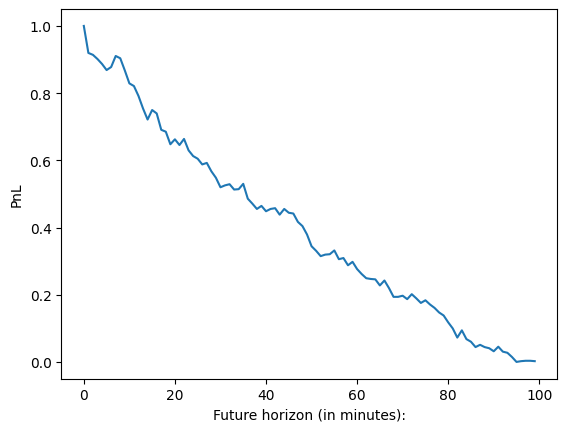

In [60]:
from sklearn.preprocessing import MinMaxScaler

reshaped_results = np.array(results).reshape(-1,1)

plt.xlabel('Future horizon (in minutes):')
plt.ylabel('PnL')

plt.plot(MinMaxScaler().fit_transform(reshaped_results))